When we deploy our TensorFlow model to a mobile or embedded device, a large model may take too long to download and use too much RAM and CPU. All of which will make our app unresponsive, heat the device and drain its battery. To avoid this, we need to make a mobile-friendly, lightweight, and efficient model, without sacrificing too much of its accuracy.

The file library provides several tools to help us deploy our TensorFlow model to a mobile and embedded devices, with three main objectives:
* Reduce the model size to shorten download time and reduce RAM usage.
* Reduce the number of computations needed for each prediction to minimize latency, battery usage, and heating.
* Adapt the model to device-specific constraints.

### Train and Deploy a TensorFlow Model to a Mobile

While we deploy a Machine Learning Model, we need to reduce the model size. **TFLite’s model converter** can take a saved model and compress it to a much lighter format based on **FlatBuffers**. This is a dynamic, cross-platform serialization library initially created by **Google** without any preprocessing: **this reduces the loading time and memory footprint**.

Once the model is loaded into a mobile or embedded device, the **TFLite interpreter** will execute it to make predictions.
Here is how we can convert a saved model to a **FlatBuffer** and save it to a `.tflite` file.

### Save/Load a `SavedModel`

We will use the **REST API** or the **gRPC API**:

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist

(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [2]:
X_train_full.shape

(60000, 28, 28)

In [3]:
X_train_full[..., np.newaxis].shape

(60000, 28, 28, 1)

In [4]:
X_train_full = X_train_full[..., np.newaxis].astype(np.float32) / 255.
X_test = X_test[..., np.newaxis].astype(np.float32) / 255.

In [5]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [6]:
X_new = X_test[:3]

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers,optimizers

np.random.seed(42)
tf.random.set_seed(42)

model = Sequential([layers.Flatten(input_shape=[28, 28, 1]),layers.Dense(100, activation="relu"),
                    layers.Dense(10, activation="softmax")])

model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizers.SGD(lr=1e-2),metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 4ms/step - loss: 1.1140 - accuracy: 0.7066 - val_loss: 0.3715 - val_accuracy: 0.9024
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3695 - accuracy: 0.8981 - val_loss: 0.2990 - val_accuracy: 0.9144
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3154 - accuracy: 0.9100 - val_loss: 0.2651 - val_accuracy: 0.9272
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2765 - accuracy: 0.9223 - val_loss: 0.2436 - val_accuracy: 0.9334
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2556 - accuracy: 0.9276 - val_loss: 0.2257 - val_accuracy: 0.9364
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2367 - accuracy: 0.9321 - val_loss: 0.2121 - val_accuracy: 0.9396
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2198 - accuracy: 0.9390 - val_loss: 0.1970 - val_accuracy

In [8]:
np.round(model.predict(X_new), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.99, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.97, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ]],
      dtype=float32)

In [9]:
import os

model_version = "0001"
model_name = "my_mnist_model"
model_path = os.path.join(model_name, model_version)
model_path

'my_mnist_model\\0001'

In [10]:
# !rm -rf {model_name}
tf.saved_model.save(model, model_path)

for root, dirs, files in os.walk(model_name):
    indent = '    ' * root.count(os.sep)
    print('{}{}/'.format(indent, os.path.basename(root)))
    for filename in files:
        print('{}{}'.format(indent + '    ', filename))

INFO:tensorflow:Assets written to: my_mnist_model\0001\assets
my_mnist_model/
    0001/
        saved_model.pb
        assets/
        variables/
            variables.data-00000-of-00001
            variables.index


In [11]:
!saved_model_cli show --dir {model_path}

The given SavedModel contains the following tag-sets:
'serve'


2021-06-16 12:04:20.010258: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll


In [12]:
!saved_model_cli show --dir {model_path} --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


2021-06-16 12:04:38.908974: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll


In [13]:
!saved_model_cli show --dir {model_path} --tag_set serve \
                      --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['flatten_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28, 1)
      name: serving_default_flatten_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2021-06-16 12:04:46.391073: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll


In [14]:
!saved_model_cli show --dir {model_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['flatten_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_flatten_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          flatte

2021-06-16 12:04:53.967919: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll


Let’s write the new instances to a `npy` file so we can pass them easily to our model:

In [15]:
np.save("my_mnist_tests.npy", X_new)
input_name = model.input_names[0]
input_name

'flatten_input'

And now let’s use `saved_model_cli` to make predictions for the instances we just saved:

In [16]:
!saved_model_cli run --dir {model_path} --tag_set serve \
                     --signature_def serving_default    \
                     --inputs {input_name}=my_mnist_tests.npy

Result for output key dense_1:
[[1.1345597e-04 1.5180355e-07 9.7037276e-04 2.7636613e-03 3.7814148e-06
  7.6850927e-05 3.9139408e-08 9.9559158e-01 5.3481705e-05 4.2660505e-04]
 [8.2481222e-04 3.5506819e-05 9.8825806e-01 7.0501668e-03 1.2966943e-07
  2.3400487e-04 2.5642337e-03 9.5967501e-10 1.0329506e-03 8.7989100e-08]
 [4.4689870e-05 9.7028804e-01 9.0506701e-03 2.2636906e-03 4.8765208e-04
  2.8796522e-03 2.2710112e-03 8.3735557e-03 4.0436476e-03 2.9753792e-04]]


2021-06-16 12:05:02.343808: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library cudart64_110.dll
2021-06-16 12:05:08.332211: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-06-16 12:05:08.336377: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2021-06-16 12:05:08.336413: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-06-16 12:05:08.864698: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-VIF6MG8
2021-06-16 12:05:08.864864: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: DESKTOP-VIF6MG8
2021-06-16 12:05:09.403391: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneD

In [17]:
np.round([[1.1345597e-04, 1.5180355e-07 ,9.7037276e-04, 2.7636613e-03, 3.7814148e-06,
  7.6850927e-05, 3.9139408e-08, 9.9559158e-01, 5.3481705e-05, 4.2660505e-04],
 [8.2481222e-04, 3.5506819e-05, 9.8825806e-01, 7.0501668e-03, 1.2966943e-07,
  2.3400487e-04, 2.5642337e-03, 9.5967501e-10, 1.0329506e-03, 8.7989100e-08],
 [4.4689870e-05, 9.7028804e-01, 9.0506701e-03, 2.2636906e-03, 4.8765208e-04,
  2.8796522e-03, 2.2710112e-03, 8.3735557e-03, 4.0436476e-03, 2.9753792e-04]],2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.99, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.97, 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ]])

### TensorFlow Serving

Install [Docker](https://docs.docker.com/get-docker/) if we don’t have it already. Then run:

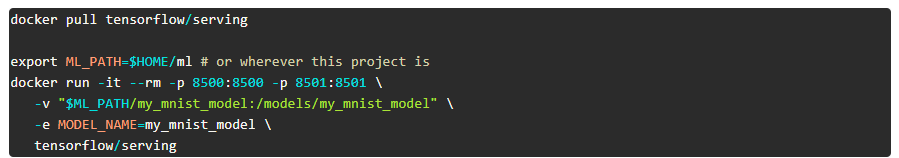

Once we are finished using it, press `Ctrl-C` to shut down the server.

Alternatively, if `tensorflow_model_server` is installed (e.g., if we are running this notebook in Colab), then the following 3 cells will start the server:

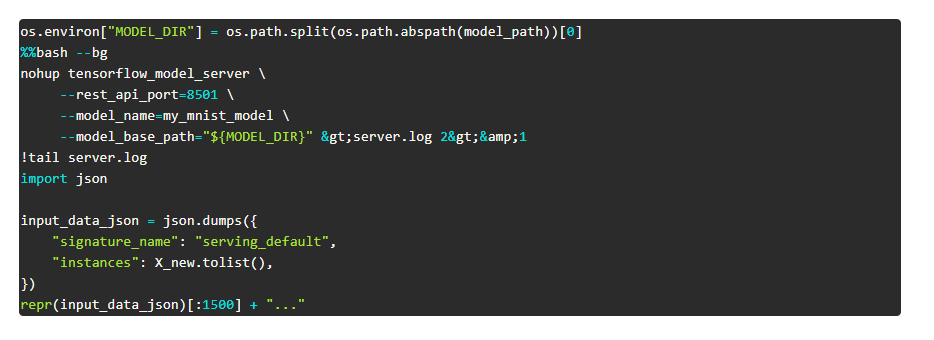

### How Does it work to Deploy a TensorFlow Model to Mobile

While we Deploy a TensorFlow model to a mobile, the converter optimizes the model, both to shrink it and to reduce its latency. It prunes all the operations that are not needed to make predictions ( such as training operations), and it optimizes computations whenever possible; for example, `3*a + 4*a +5*a` will be converted to `(3+4+5)*a`. It also tries to fuse operations whenever possible.

For example, Batch Normalization layers end up folded into pervious layer’s addition and multiplication operations, whenever possible. To get a good idea of how much **TFLite** can optimize a model, 
* download one of the pretrained **TFLite models**, 
* unzip the archive,
* then open the excellent Netron graph visualization tool and upload the `.pb` file to view the original model. It’s a big, elaborate graph. 
* Next, open the optimized. Tflite model marvel at its beauty.

### Another Way to Reduce the Model Size

Another way we can reduce the model size while we deploy a TensorFlow model to a mobile or embedded device (other than only using smaller neural network architectures) is by using smaller bit-widths: for example, if we use half-floats (`16 bits`) rather than regular floats (`32 bits`), the model size will shrink by a factor of 2, at the cost of a (generally small) accuracy drop. Moreover, training will be faster, and we will use roughly half the amount of GPU RAM.

**TFLite’s converter** can go further than that, by quantizing the model weights down to fixed- point, 8-bit integers! This leads to a fourfold size reduction compared to using 32-bit floats, 8-bit integers! This leads to a fourfold size reduction compared to using 32-bit floats.

The simplest approach is called **post-training quantization**: it just **quantizes the weights** after training, using a fairly basic but efficient symmetrical quantization technique. It finds the maximum absolute weight value, `m`; then it maps the floating-point range `–m` to `+m` to the fixed-point (integer) range `-127` to `+127`.